# Install dependencies

* IMPORTANT: you only need to run this one time, when you first spin up your docker notebook server
* IMPORTANT: you need to restart the kernel after you run this
* TODO: these deps should be eventually put into a dockerfile

* INFO: read more about [what the hell is pip](https://pip.pypa.io/en/stable/) and [why installing dependencies via pip in a notebook is a stupid idea, but OK since we are prototyping here](https://towardsdev.com/pip-install-from-jupyter-notebook-485c218b50b)

In [ ]:
!pip install pandas
!pip install datasets

# Import libraries

also setup the data directory

In [41]:
import os
import re
import glob
import shutil
import string
import pathlib


# set the data directory
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','data'))

#give matplotlib a folder to save its configs
os.environ['MPLCONFIGDIR'] = os.path.join(data_dir,'plt_configs')
import matplotlib.pyplot as plt

#give huggingface a folder to save its stuff in too
#you only need this if you are using a huggingface dataset
os.environ['HF_HOME'] = os.path.join(data_dir,'hf_cache')
import datasets

import PIL
import PIL.Image

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import TextVectorization

In [2]:
# setup directories, create them if they do not exist within data folder

# We want our data directory to contain two folders, one for each class we are predicting ("headshots" aka normalish photos of normalish people (I guess) or "mugshots")

animals_dir = os.path.join(data_dir,'animals')
if not os.path.exists(animals_dir):
    os.makedirs(animals_dir)
    
cats_dir = os.path.join(data_dir,'animals','cats')
if not os.path.exists(cats_dir):
    os.makedirs(cats_dir)
    
dogs_dir = os.path.join(data_dir,'animals','dogs')
if not os.path.exists(dogs_dir):
    os.makedirs(dogs_dir)

# Download the data, part 1 "control group" faces from huggingface and inspect the data

* [huggingface datasets quickstart](https://huggingface.co/docs/datasets/quickstart)
* [nielsr/CelebA-faces](https://huggingface.co/datasets/nielsr/CelebA-faces)
* [Know your dataset](https://huggingface.co/docs/datasets/access)

In [3]:
# Loading the dataset
dataset = datasets.load_dataset("cats_vs_dogs")

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /tf/data/hf_cache/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
# Printing first 5 records from dataset
animals_dataset = dataset['train'].to_pandas()
animals_dataset.head()

,image,labels
0,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
1,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
2,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
3,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
4,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0


In [51]:
# dividing the dataset into 2 dataframes
cats_df = animals_dataset[animals_dataset['labels'] == 0]
dogs_df = animals_dataset[animals_dataset['labels'] == 1]

In [52]:
# printing first 5 records of cats dataset
cats_df.head()

,image,labels
0,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
1,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
2,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
3,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
4,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0


In [53]:
# printing path of first data of cats dataset
cats_df['image'][0]['path']

'/tf/data/hf_cache/datasets/downloads/extracted/c4333ea05164292151dda37c31bffe1889dba836e9f80c21a02e1063e61efbea/PetImages/Cat/0.jpg'

In [54]:
for i in range(len(cats_df)):
    shutil.copyfile(cats_df['image'][i]['path'], os.path.join(cats_dir,str(i)+'.jpg'))

In [55]:
# printing the count of cat images available in the cat directory
image_count = len(list(pathlib.Path(cats_dir).glob('*.jpg')))
print(image_count)

11741


(492, 500)


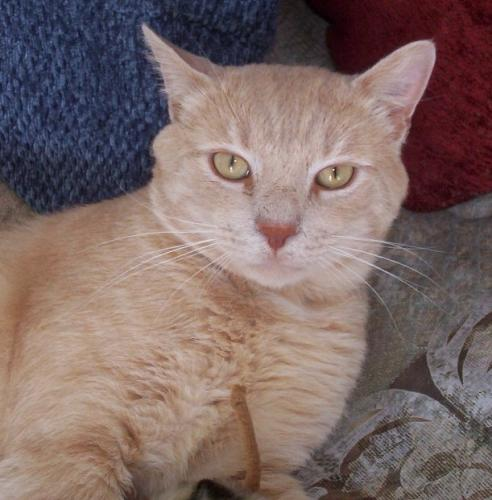

In [56]:
# Print the first image from cats directory
cats = list(pathlib.Path(cats_dir).glob('*.jpg'))
print(PIL.Image.open(str(cats[0])).size)
PIL.Image.open(str(cats[0]))

(500, 375)


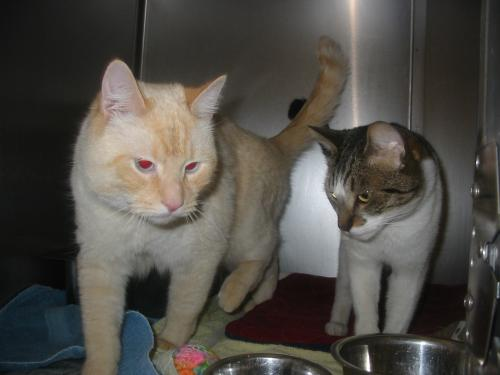

In [58]:
# Print the second image from cats directory
print(PIL.Image.open(str(cats[1])).size)
PIL.Image.open(str(cats[1]))

(500, 411)


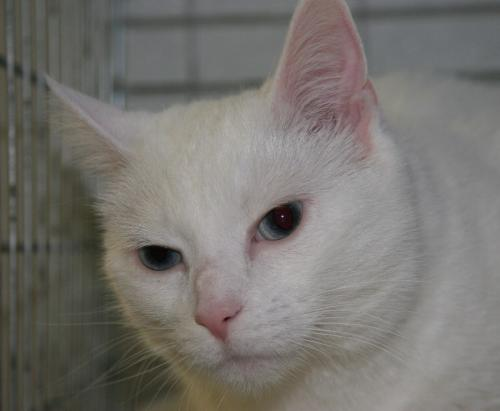

In [59]:
# Print the last image from cats directory
print(PIL.Image.open(str(cats[-1])).size)
PIL.Image.open(str(cats[-1]))

In [60]:
# printing first 5 records of dogs dataset
dogs_df.head()

,image,labels
11741,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11742,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11743,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11744,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11745,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1


In [62]:
dogs_df['image'][11741]['path']

'/tf/data/hf_cache/datasets/downloads/extracted/c4333ea05164292151dda37c31bffe1889dba836e9f80c21a02e1063e61efbea/PetImages/Dog/0.jpg'

In [66]:
i = 11741
for i in range(len(dogs_df)):
    shutil.copyfile(dogs_df['image'][i]['path'], os.path.join(dogs_dir,str(i)+'.jpg'))

KeyError: 0

(500, 375)


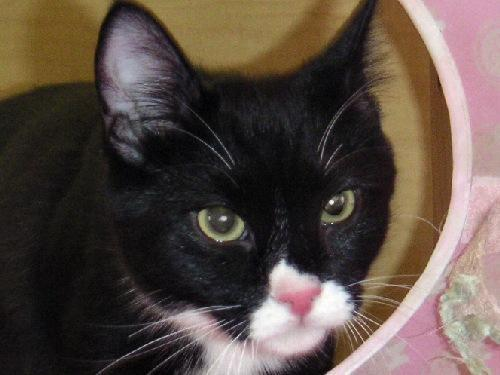

# load the mugshat data from the '/data' folder
* [load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images)

In [11]:
image_count = len(list(pathlib.Path(dogs_dir).glob('*.jpg')))
print(image_count)

0


In [ ]:
mugshots = list(pathlib.Path(mugshots_dir).glob('*.jpg'))
print(PIL.Image.open(str(mugshots[0])).size)
PIL.Image.open(str(mugshots[0]))

# Setup Training Set

In [ ]:
batch_size = 2 #TODO Change this to something more reasonable, try 32 to start
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(faces_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(faces_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
print(class_names)

# [Standardize and Fit](https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data)

[https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data](https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data)

In [ ]:
plt.figure(figsize=(2, 2))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

# Save model and test prediction

In [ ]:
# TODO add code here